## Fit AR(1) to data main analysis + control analysis (control for SNR)
04/09/25

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import cortex
from cortex import database
DB = database.Database(cortex.db.filestore)
cortex.db = DB
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import h5py
import os
import nibabel as nib
from collections import defaultdict 
import statsmodels.api as sm
np.random.seed(0)

In [ ]:
path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data'
fig_path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/figures'
os.chdir(path=path)
cwd = os.getcwd()  # Get current working directory
print("Current Working Directory:", cwd)

##### Load language data

In [8]:
from pathlib import Path
from functools import lru_cache
stories = [
    "wheretheressmoke",
    "fromboyhoodtofatherhood",
    "onapproachtopluto",
]
subject_xfm = {
    'AA': '20180905AA-sg-auto',
    'AHfs': '20180816AH-sg',
    'S1': '20180414SJ-sg_auto3',
    'S4': '20190121SS_auto',
    'S5': '20190715_sg_auto',
    'S6': '20190910IG_sg_auto',
    'S7': '20190916RA_auto',
    'BFD001': '20220421BFD001-sg-auto',
    'BFD003': '20230730BFD003-sg-auto'
}
base_dir = Path("/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/language")

def hf5_path(subject:str, story:str) -> Path:
    return base_dir / f"{story}" / f"{subject}_{story}.hf5"

@lru_cache(maxsize=None)
def load_response_trials(subject: str, story: str, drop_first_trs: int = 50) -> np.ndarray:
    path = hf5_path(subject, story)
    with h5py.File(path, "r") as f:
        dsname = next(iter(f.keys()))
        arr = f[dsname][:]
    if drop_first_trs:
        arr = arr[:, drop_first_trs:, :]
    return arr

@lru_cache(maxsize=None)
def load_mask(subject: str) -> np.ndarray:
    xfm = subject_xfm[subject]
    return DB.get_mask(subject, xfm)

def get_xfm(subject: str) -> str:
    return subject_xfm[subject]

In [9]:
subject = "S1"
story = "onapproachtopluto"
# load mask
xfm = get_xfm(subject)
mask = load_mask(subject)
# load resp data
response_trials = load_response_trials(subject, story)
print(response_trials.shape, mask.shape)

(4, 221, 81126) (54, 84, 84)


In [10]:
# choose functional roi 
f_rois = ['AC','sPMv']
# f_rois = ['V1','V2','V3','IPS', 'EBA', 'FEF']  
f_roi_voxs = {} # get indices of roi voxels in cortical map
# get 3d mask of voxels that belong to roi
roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)

for roi in f_rois:
    roi_mask = roi_masks[roi]
    f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

# choose anatomical roi (PFC & precuneus)
path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/rois' # language
# path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/vision_fixation' # vision

os.chdir(path=path)
a_roi = ['parsopercularis','parstriangularis','superiorfrontal','rostralmiddlefrontal','caudalmiddlefrontal','frontalpole','precuneus']
roi_data = np.load(f'{subject}_roi.npy', allow_pickle=True).item()
a_roi_voxs = {}
for roi in a_roi:
    a_roi_voxs[roi] = roi_data[roi]
    
# combine PFC rois
rois_to_combine = [
    'parsopercularis',
    'parstriangularis',
    'superiorfrontal',
    'rostralmiddlefrontal',
    'caudalmiddlefrontal',
    'frontalpole'
]
pfc_voxs = []
for roi in rois_to_combine:
    pfc_voxs.extend(a_roi_voxs[roi])
    
pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

for roi in rois_to_combine: # remove old keys
    del a_roi_voxs[roi]


# combine functional and anatomical
roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

# print number of voxels in each ROI
len(roi_voxs)
for key, value in roi_voxs.items():
    print(f"{key}: {len(value)} items")

Cutting 0 overlapping voxels (should be < ~50)
AC: 1431 items
sPMv: 149 items
precuneus: 2262 items
prefrontal: 12311 items


##### Load A1 and non-A1 voxel indices

In [16]:
script_path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/scripts'
os.chdir(path=script_path)
A1_voxs = np.load("A1_voxels.npy")
nonA1_voxs = np.load("nonA1_voxels.npy")
roi_voxs = {
    "A1": A1_voxs,
    "nonA1": nonA1_voxs
}
print(roi_voxs["A1"].shape)
print(roi_voxs["nonA1"].shape)

(156,)
(3545,)


##### Load vision data

In [ ]:
if 0:
    # path = '/Users/jiamingxu/Desktop/Language_straightening/data/language/AA_wheretheressmoke.hf5'
    # path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/language/AA_wheretheressmoke.hf5'
    data_path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/vision_fixation/vision_fixation_resp.hf5'
    dir = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/vision_fixation'

    with h5py.File(data_path, 'r') as file:
        file_name = list(file.keys())[0]
        response_trials = np.array(file[file_name])
        # get rid of the first 50 TRs (due to onset effect in AC)
        response_trials = response_trials[:, 50:, :]
        print(response_trials.shape) 

    # subject, xfm = 'AA', '20180905AA-sg-auto'
    subject, xfm = 'S1', 'fullhead'
    mask = cortex.db.get_mask(subject, xfm)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/data/vision_fixation/vision_fixation_resp.hf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
if 0:
    # load VISION anatomical data
    lab_l,ctab_l,names_l = nib.freesurfer.read_annot(f'{dir}/{subject}/label/lh.aparc.annot')
    print(lab_l.shape, ctab_l.shape, len(names_l))

    lab_r,ctab_r,names_r = nib.freesurfer.read_annot(f'{dir}/{subject}/label/rh.aparc.annot')
    print(lab_r.shape, ctab_r.shape, len(names_r))

    assert np.all(names_l == names_r)
    names = [n.decode("utf-8") for n in names_l]

    # choose functional rois
    f_rois = ['V1','V2','V3','IPS', 'EBA', 'FEF']  
    f_roi_voxs = {} 
    # get 3d mask of voxels that belong to roi
    roi_masks = cortex.utils.get_roi_masks(subject, xfm, roi_list=f_rois, gm_sampler='cortical', split_lr=False, threshold=None, return_dict=True)
    for roi in f_rois:
        roi_mask = roi_masks[roi]
        f_roi_voxs[roi] = np.where(roi_mask[np.where(mask)])[0]

    # choose anatomical rois
    a_rois = [
        'parsopercularis',
        'parstriangularis',
        'superiorfrontal',
        'rostralmiddlefrontal',
        'caudalmiddlefrontal',
        'frontalpole'
    ]
    # combine PFC voxels
    rois_to_combine = [
        'parsopercularis',
        'parstriangularis',
        'superiorfrontal',
        'rostralmiddlefrontal',
        'caudalmiddlefrontal',
        'frontalpole'
    ]
    # get mask
    mask = cortex.db.get_mask(subject, xfm)
    Mapper = cortex.get_mapper(subject, xfm, 'line_nearest')
    Map_l = Mapper.masks[0][:, mask.ravel()]
    Map_r = Mapper.masks[1][:, mask.ravel()]

    a_roi_voxs = {}

    for lm in range(len(a_rois)):
        vert_l = set((lab_l==lm).nonzero()[0].tolist())
        vert_r = set((lab_r==lm).nonzero()[0].tolist())
        vox_l = Map_l[list(vert_l), :].nonzero()[1]
        vox_r = Map_r[list(vert_r), :].nonzero()[1]
        a_roi_voxs[a_rois[lm]] = np.sort(list(set(map(int, np.hstack([vox_r, vox_l])))))

    pfc_voxs = []
    for roi in rois_to_combine:
        pfc_voxs.extend(a_roi_voxs[roi])
        
    pfc_voxs = list(set(pfc_voxs)) # remove potential duplicates

    a_roi_voxs['prefrontal'] = pfc_voxs # update dict 

    for roi in rois_to_combine: # remove old keys
        del a_roi_voxs[roi]

    # combine functional and anatomical
    roi_voxs = {**f_roi_voxs, **a_roi_voxs}  

    # print number of voxels in each ROI
    len(roi_voxs)
    for key, value in roi_voxs.items():
        print(f"{key}: {len(value)} items")

FileNotFoundError: [Errno 2] No such file or directory: '<built-in function dir>/AA/label/lh.aparc.annot'

### Direct curvature estimates 

In [ ]:
def avg_pop_curvature(X):
    # X: (n_series, nT)
    V = X[:, 1:] - X[:, :-1] #(n_series, nT-1)
    norms = np.linalg.norm(V, axis=0) #(nT-1,)
    dots = (V[:, 1:] * V[:, :-1]).sum(0)
    coss = dots / (norms[1:] * norms[:-1])
    angles = np.degrees(np.arccos(coss))
    return angles.mean()  # return mean curvature across series

AC curvature: 114.74
sPMv curvature: 114.61
precuneus curvature: 111.46
prefrontal curvature: 110.69


(90.0, 120.0)

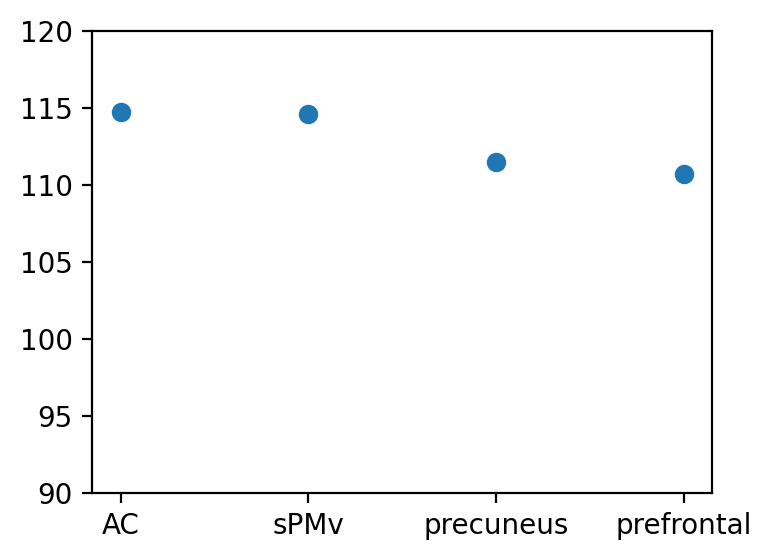

In [ ]:
run_avg_resp = np.mean(response_trials, axis=0) # (nT, voxels) 
dir_roi_curv = {}
for roi in roi_voxs:
    roi_voxels = roi_voxs[roi]
    curvature = avg_pop_curvature(run_avg_resp[:, roi_voxels])  # calculate curvature
    dir_roi_curv[roi] = curvature
    print(f'{roi} curvature: {curvature:.2f}')  # print curvature value

roi_names = list(dir_roi_curv.keys())
roi_dir_curv = list(dir_roi_curv.values())
plt.figure(figsize=(4,3))
plt.plot(roi_names, roi_dir_curv, "o")
plt.ylim([90, 120])

Bootstrap

In [ ]:
if 0:
    nboots = 100
    nruns = response_trials.shape[0]  
    nT = response_trials.shape[1]

    boot_dir_roi_curv = {roi: np.zeros(nboots) for roi in roi_voxs}

    for b in range(nboots):
        # 1) resample runs
        sample_idx = np.random.choice(response_trials.shape[0],
                                    size=nruns,
                                    replace=True)
        sample_trials = response_trials[sample_idx, :, :]   # (nruns, nT, Nvox)

        # 2) run-average
        boot_run_avg = sample_trials.mean(axis=0)           # (nT, Nvox)

        # 3) compute curvature for each ROI
        for roi, vox in roi_voxs.items():
            curv = avg_pop_curvature(boot_run_avg[:, vox])  # (nT, ROI_vox)
            boot_dir_roi_curv[roi][b] = curv


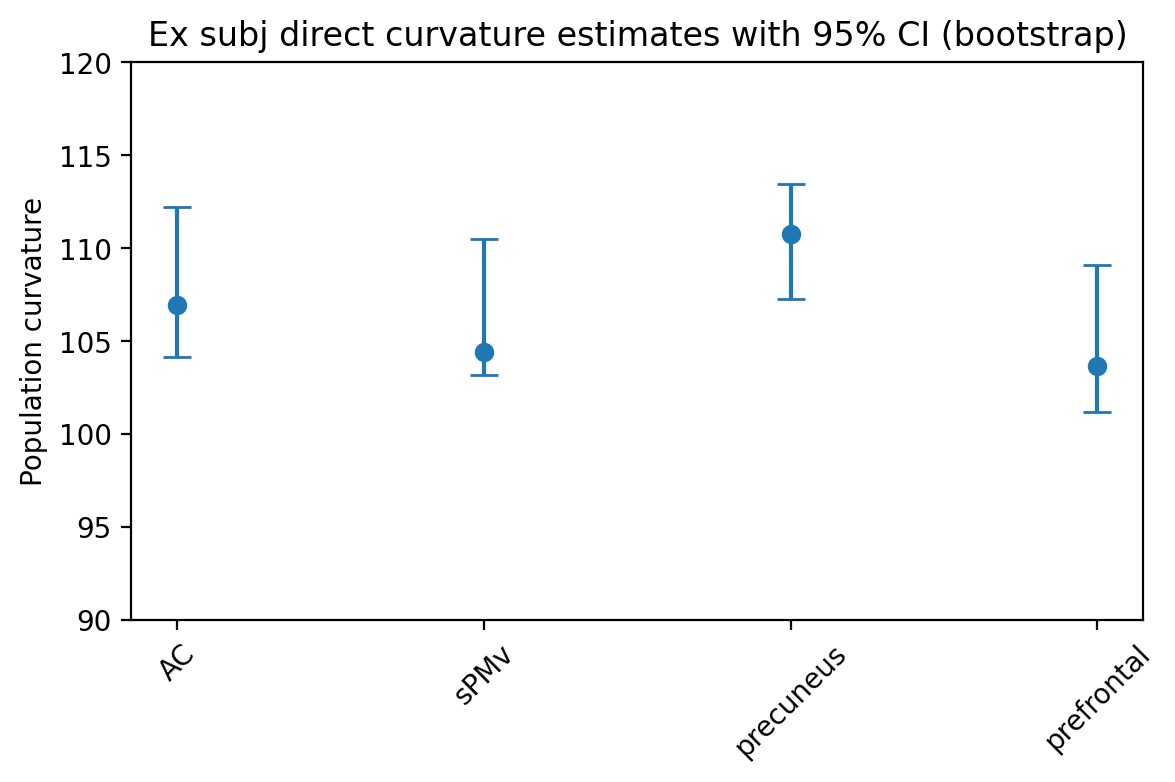

In [ ]:
if 0:
    roi_names = list(roi_voxs.keys())
    point_est = np.array([dir_roi_curv[roi] for roi in roi_names])

    lower_err = []
    upper_err = []

    for roi, est in zip(roi_names, point_est):
        dist = boot_dir_roi_curv[roi]
        lb = np.percentile(dist, 2.5)
        ub = np.percentile(dist, 97.5)
        lower_err.append(est - lb)
        upper_err.append(ub - est)

    err_bar = [lower_err, upper_err]


    plt.figure(figsize=(6,4))
    x = np.arange(len(roi_names))
    plt.errorbar(x, point_est, yerr=err_bar, fmt='o', capsize=5)
    plt.xticks(x, roi_names, rotation=45)
    plt.ylim([90, 120])
    plt.ylabel("Population curvature")
    plt.title("Ex subj direct curvature estimates with 95% CI (bootstrap)")
    plt.tight_layout()
    plt.savefig("ex_subj_direct_curv.pdf", format='pdf')
    plt.show()


### Fit AR(1) to run average 

##### Get AR(1) coefficient map 

In [ ]:
if 0:
    # data
    zs = lambda v: (v-v.mean(0))/(v.std(0) + 1e-8)
    avg_reps = np.mean(response_trials,0) 
    voxel_ar1 = np.empty(avg_reps.shape[1], dtype=float)
    for voxel_idx in range(avg_reps.shape[1]):
        voxel_demean_resp = zs(avg_reps[:,voxel_idx]) #1d (time,)
        ar1_model = sm.tsa.AutoReg(voxel_demean_resp, lags = 1).fit()
        voxel_ar1[voxel_idx] = ar1_model.params[1]


In [ ]:
if 0:
    # alpha (compute coherence as repeatability)
    from scipy.signal import welch

    def compute_coherence_spectrum(data, fs, nfft=64):
        """
        data: (repeats, time, voxels)
        """
        R, T, V = data.shape
        nperseg = min(nfft, T)          # ensure consistent segment size
        noverlap = nperseg // 2
        params = dict(nperseg=nperseg, fs=fs, noverlap=noverlap)

        # signal: mean across repeats, PSD along time axis
        signal = data.mean(axis=0)                      # (T, V)
        freqs, spower = welch(signal, axis=0, **params) # (F, V)

        # noise: trial-by-trial residuals from the mean
        noise = data - signal[None, :, :]               # (R, T, V)
        _, noise_psd = welch(noise, axis=1, **params)   # (R, F, V)
        npower = noise_psd.mean(axis=0)                 # (F, V)

        # jackknife residuals: leave-one-out mean
        sum_all = data.sum(axis=0, keepdims=True)       # (1, T, V)
        mean_loo = (sum_all - data) / (R - 1)           # (R, T, V)
        jnoises = data - mean_loo                       # (R, T, V)
        _, jn_psd = welch(jnoises, axis=1, **params)    # (R, F, V)
        jnpower = jn_psd.mean(axis=0)                   # (F, V)

        # coherence estimates (clip to [0,1] to be safe)
        coherence_upper = spower / (npower + spower)
        coherence_lower = spower / (jnpower + spower)
        coherence_upper = np.clip(coherence_upper, 0, 1)
        coherence_lower = np.clip(coherence_lower, 0, 1)

        return freqs, spower, npower, jnpower, coherence_upper, coherence_lower


    freqs,_,_,_,_,coherence_lower = compute_coherence_spectrum(response_trials, fs=0.5, nfft=64)
    print(coherence_lower.shape)
    print(np.nanmin(coherence_lower), np.nanmax(coherence_lower))


(33, 94251)
0.0006579335957497766 0.6843420590603203


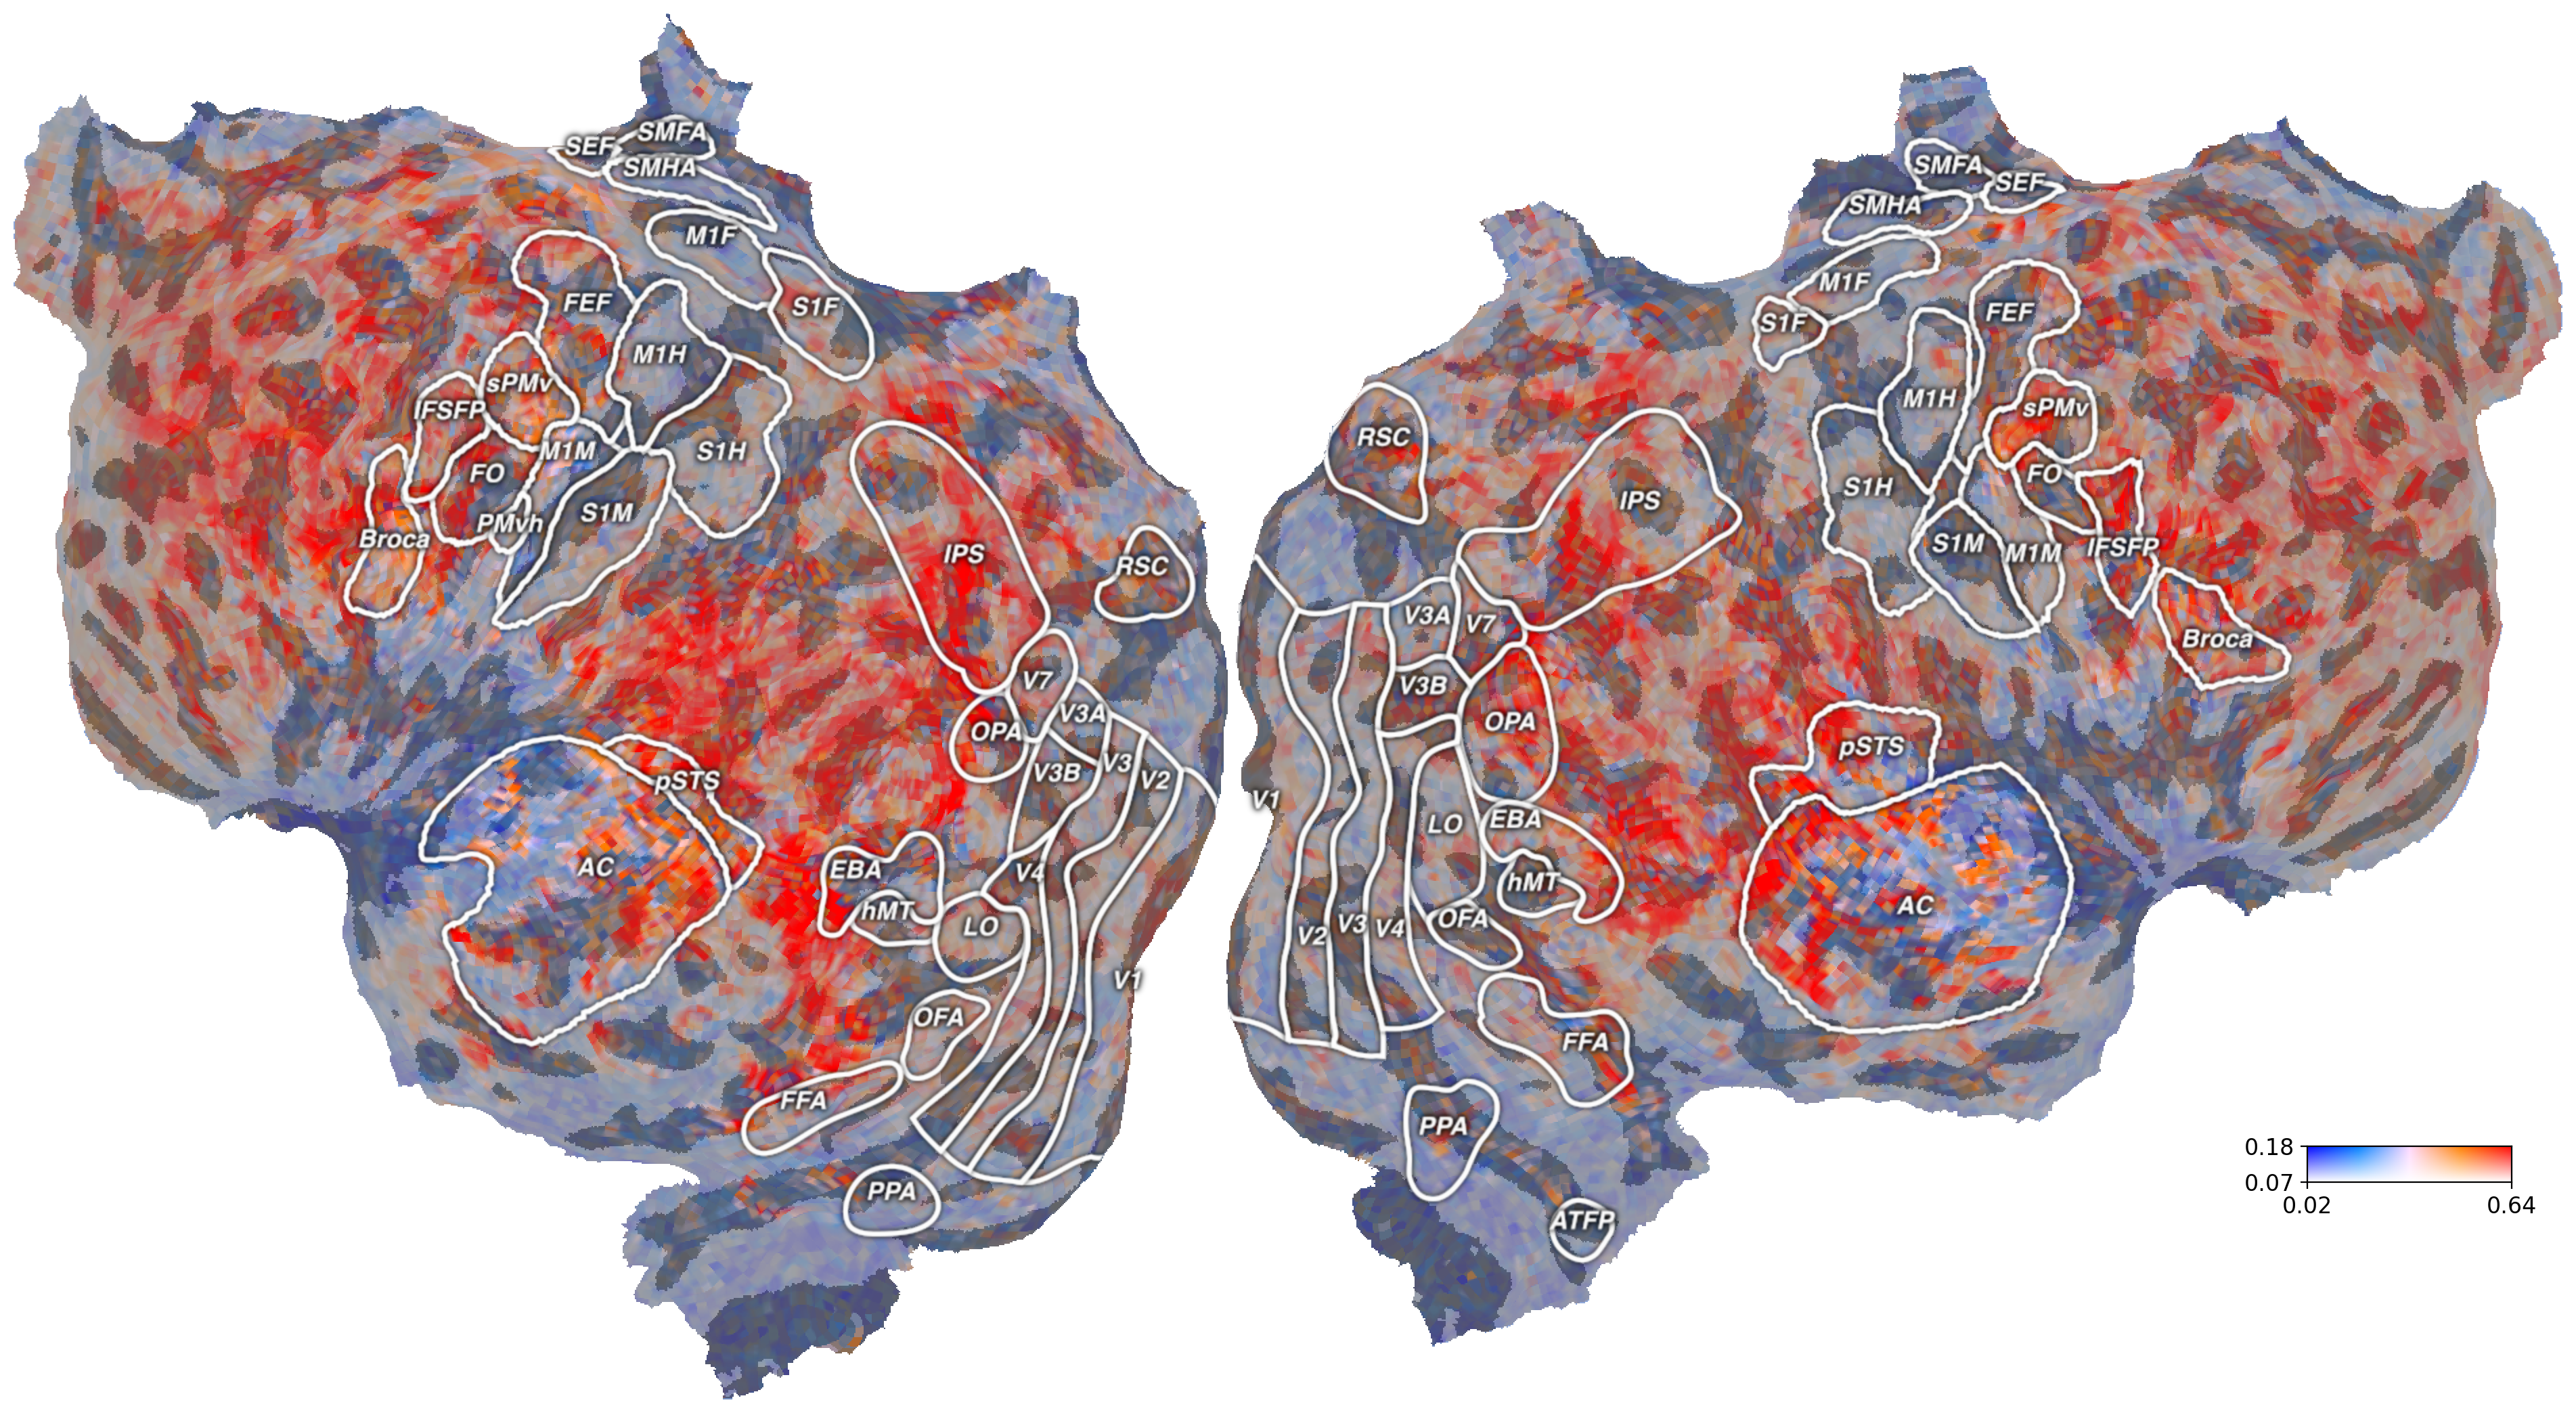

In [ ]:
if 0:
    flatmap_kwargs = {'recache': False, 'pixelwise': True, 'sampler': 'nearest',
        'height': 1024, 'with_rois': True, #'with_labels': False, 
        'with_curvature': True, 'curvature_threshold': True, 'linewidth': 4,
        'nanmean': True}

    # get weighted average of frequency bins by coherence - find the center of mass of the coherence spectrum
    vmin, vmax = np.percentile(voxel_ar1[np.isfinite(voxel_ar1)], [10, 90])
    alpha_vox = np.nanmean(coherence_lower, axis=0)
    vol2d = cortex.Volume2D(
        voxel_ar1,               # color = AR(1) per voxel
        alpha_vox,               # alpha = coherence-based reliability
        subject, xfmname=xfm,
        cmap='BuWtRd_alpha',   
        vmin=vmin, vmax=vmax
    )

    colorbar_location = (0.90, -0.08, 0.08, 0.5)
    os.chdir(path=fig_path)
    cortex.quickshow(vol2d, colorbar_location = colorbar_location, **flatmap_kwargs)
    plt.savefig("ar1_flatmap.pdf", format='pdf', bbox_inches='tight')



In [ ]:
if 0:
    plt.hist(alpha_vox[np.isfinite(alpha_vox)], bins=100)
    plt.xlabel("Coherence")
    plt.ylabel("Voxel count")
    plt.title("Distribution of voxel coherence")

NameError: name 'alpha_vox' is not defined

In [ ]:
if 0:    
    print(np.nanmin(alpha_vox), np.nanmax(alpha_vox), np.nanmean(alpha_vox))
    print(voxel_ar1.shape, alpha_vox.shape)
    print(np.isnan(alpha_vox).sum(), alpha_vox.size)
    print(np.sum(mask), np.prod(mask.shape))


0.05542515711067328 0.428327691342939 0.09743044019820458
(94251,) (94251,)
0 94251
94251 94251


##### fit AR(1) to ROI averages

Text(0.5, 1.0, 'S1, onapproachtopluto, 4 reps')

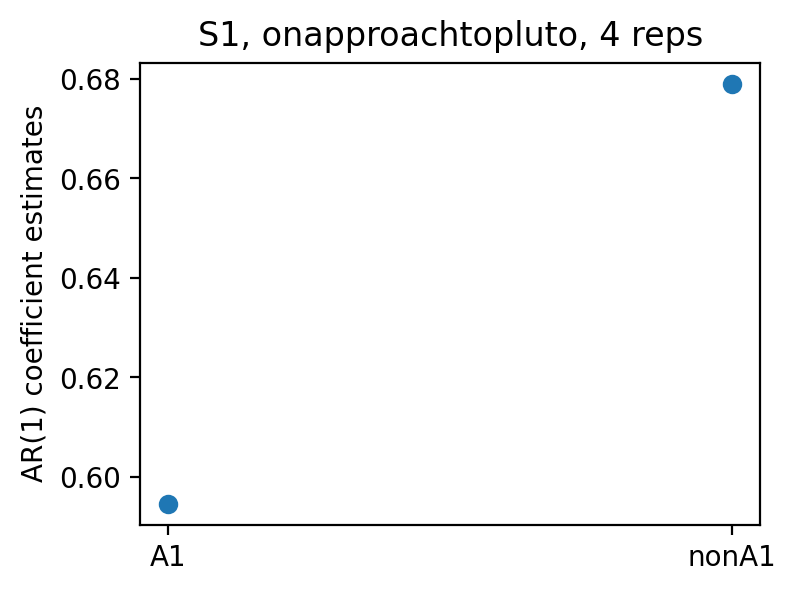

In [13]:
zs = lambda v: (v-v.mean(0))/(v.std(0) + 1e-8)
avg_reps = np.mean(response_trials, axis=0)
roi_ar1_coeff = {}
roi_voxel_ar1_coeff = {} 

# 1) Fit to voxel average
for roi in roi_voxs:
    roi_demean_resp = zs(np.mean(avg_reps[:,roi_voxs[roi]], axis=1)) # run average x voxel average
    ar1_model = sm.tsa.AutoReg(roi_demean_resp, lags = 1).fit()
    roi_ar1_coeff[roi] = ar1_model.params[1]

roi_names = list(roi_ar1_coeff.keys())
roi_ar1 = list(roi_ar1_coeff.values())
plt.figure(figsize=(4,3))
plt.plot(roi_names, roi_ar1, "o")
plt.ylabel("AR(1) coefficient estimates")
plt.title(f"{subject}, {story}, {response_trials.shape[0]}"+" reps")


# 2) Voxel-by-voxel 
# for roi, vox_idx in roi_voxs.items():
#     # vox_idx: list/array of voxel indices belonging to this ROI
#     voxel_ar1 = np.empty(len(vox_idx), dtype=float)
#     models = []

#     for i, v in enumerate(vox_idx):
#         voxel_demean_resp = zs(avg_reps[:, v])  # 1D (time,)
#         ar1_model = sm.tsa.AutoReg(voxel_demean_resp, lags=1).fit()
#         voxel_ar1[i] = ar1_model.params[1]

#     roi_voxel_ar1_coeff[roi] = voxel_ar1          
#     roi_ar1_coeff[roi] = voxel_ar1.mean()   # mean AR(1) across voxels



In [ ]:
stop 

##### Noise ceiling plots

In [ ]:
if 0:
    roi_ar1_coeff_nc = []
    for num_trials in range(1, response_trials.shape[0]+1):
        avg_reps_nc = np.mean(response_trials[:num_trials,:,:],axis=0)
        
        this_level = []  # list of [roi_name, ar1_coeff] for this noise level
        for roi in roi_voxs:
            # run average across trials → then voxel average inside ROI
            roi_demean_resp = zs(np.mean(avg_reps_nc[:, roi_voxs[roi]], axis=1))
            ar1_model = sm.tsa.AutoReg(roi_demean_resp, lags=1).fit()
            this_level.append([roi, float(ar1_model.params[1])])
        roi_ar1_coeff_nc.append(this_level)


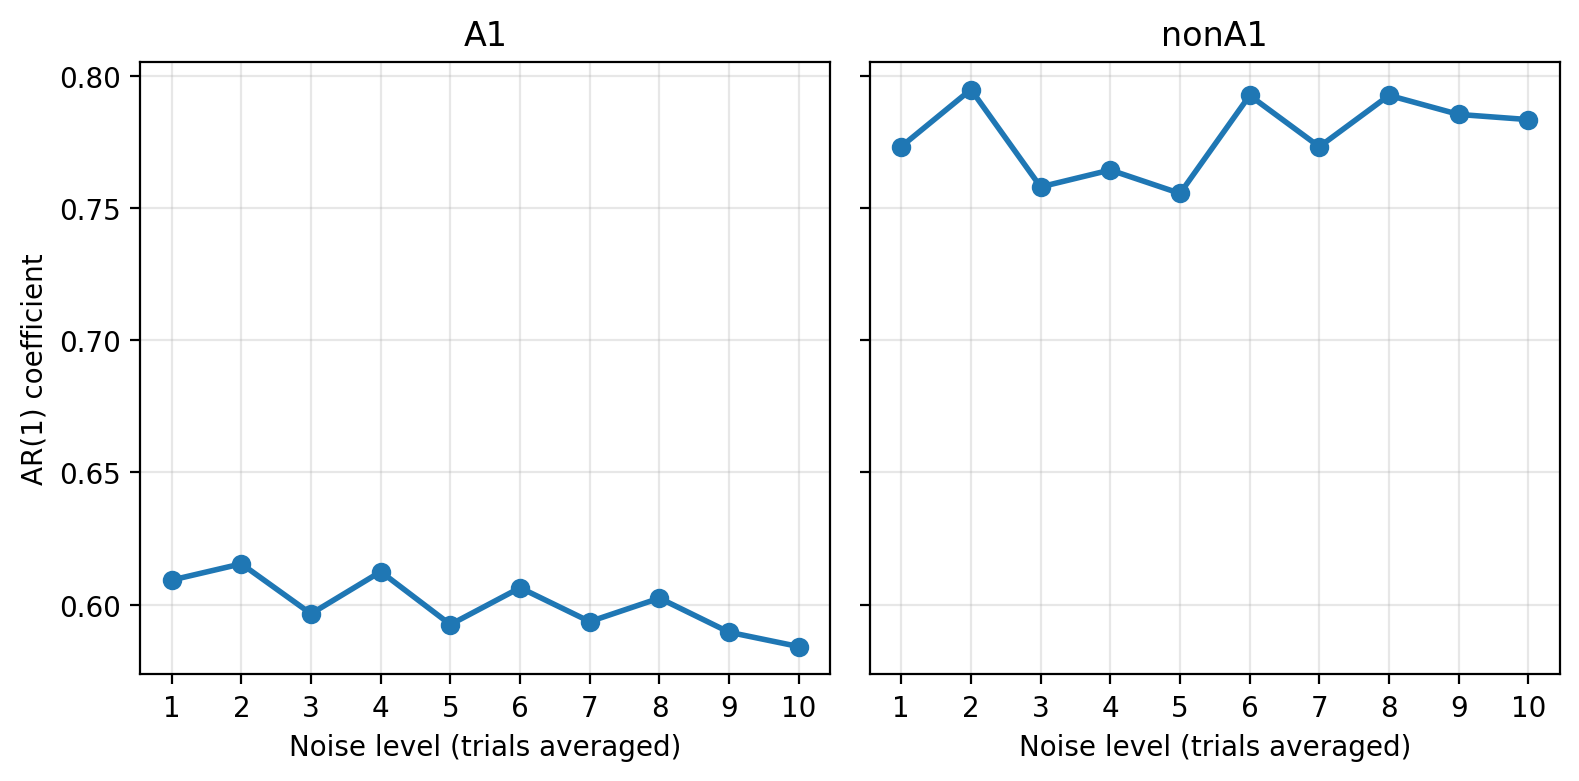

In [ ]:
if 0:

    import matplotlib.pyplot as plt
    import numpy as np

    roi_names = list(roi_voxs.keys())
    n_levels = len(roi_ar1_coeff_nc)

    # Convert to matrix shape: (n_levels × n_rois)
    ar1_matrix = np.zeros((n_levels, len(roi_names)))
    for i, level_data in enumerate(roi_ar1_coeff_nc):
        for j, (roi, ar1_val) in enumerate(level_data):
            ar1_matrix[i, j] = ar1_val

    # Plot 4 subplots (one per ROI)
    fig, axes = plt.subplots(1, len(roi_names), figsize=(4 * len(roi_names), 4), sharey=True)

    for j, roi in enumerate(roi_names):
        ax = axes[j] if len(roi_names) > 1 else axes
        ax.plot(range(1, n_levels + 1), ar1_matrix[:, j], marker='o', linewidth=2)
        ax.set_title(roi)
        ax.set_xlabel("Noise level (trials averaged)")
        if j == 0:
            ax.set_ylabel("AR(1) coefficient")
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(1, n_levels + 1))

    plt.tight_layout()
    plt.show()



##### Indirect estimates of curvature through AR(1) fits

NameError: name 'fig_path' is not defined

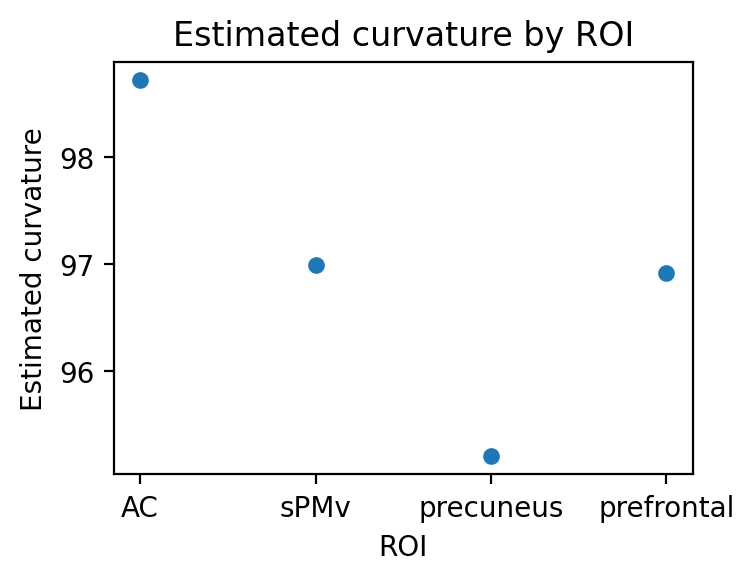

In [ ]:
private_signal_std = 1.0  # same as simulation setting
def make_noiseless_arp(ar_coeff, nT, n_voxs, private_signal_innov):
    time_series = np.zeros((n_voxs, nT))
    time_series[:,0] = private_signal_innov[:,0]
    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + private_signal_innov[:,t]
        
    return time_series #(n_voxs, nT)

# n_voxs = []
# for key, value in roi_voxs.items():
#     n_voxs.append(len(value))

nT = response_trials.shape[1]
roi_names = list(roi_ar1_coeff.keys())
rec_noiseless_est_curv = {roi: None for roi in roi_voxs}


for roi in roi_voxs:
    # get n_voxs for this ROI
    n_voxs_roi = len(roi_voxs[roi])
    # n_voxs.append(n_voxs_roi)

    # get the ar1 coeff est for this ROI
    alpha = roi_ar1_coeff[roi]

    # make noiseless ts using the estimated ar1 coeff of this ROI
    private_signal_innov = np.random.randn(n_voxs_roi, nT) * private_signal_std
    roi_rec_noiseless_ts = np.zeros((n_voxs_roi, nT))
    roi_rec_noiseless_ts = make_noiseless_arp(alpha, nT, n_voxs_roi, private_signal_innov)

    # calculate population trajectory curvature 
    rec_noiseless_est_curv[roi] = avg_pop_curvature(roi_rec_noiseless_ts)

rec_curv = rec_noiseless_est_curv.values()



plt.figure(figsize=(4, 3))
plt.plot(roi_names, rec_curv, 'o', markersize=5)

plt.xlabel("ROI")
plt.ylabel("Estimated curvature")
plt.title("Estimated curvature by ROI")
plt.suptitle(f"{subject}, {story}, {response_trials.shape[0]} reps", fontsize=10, y=0.98)
# plt.ylim(-0.1, max(rec_noisy_est_curv) * 1.2)  # optional for nicer spacing
plt.tight_layout()
os.chdir(path=fig_path)
# plt.savefig("roi_curvature_s1.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(rec_curv)

#### Bootstrap to get 95% CI for AR coeff estimates
Sample 10 runs with replacement, find run average and fit to AR(1) model for each ROI. Repeat this process 100 times to get the null distribution of AR(1) coefficients. Then get error bars to see if differences between ROIs are significant. 


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 μs
95% CI: [(np.float64(0.6569176321562774), np.float64(0.7391598367752383)), (np.float64(0.6981693816512253), np.float64(0.7741278555297698)), (np.float64(0.7683708982553499), np.float64(0.8620789800725926)), (np.float64(0.7626481130749233), np.float64(0.8949235627383195))]
AR(1) Coefficient Estimates: [np.float64(0.7073899814041537), np.float64(0.7480381752416411), np.float64(0.852912045864911), np.float64(0.8745606639787582)]


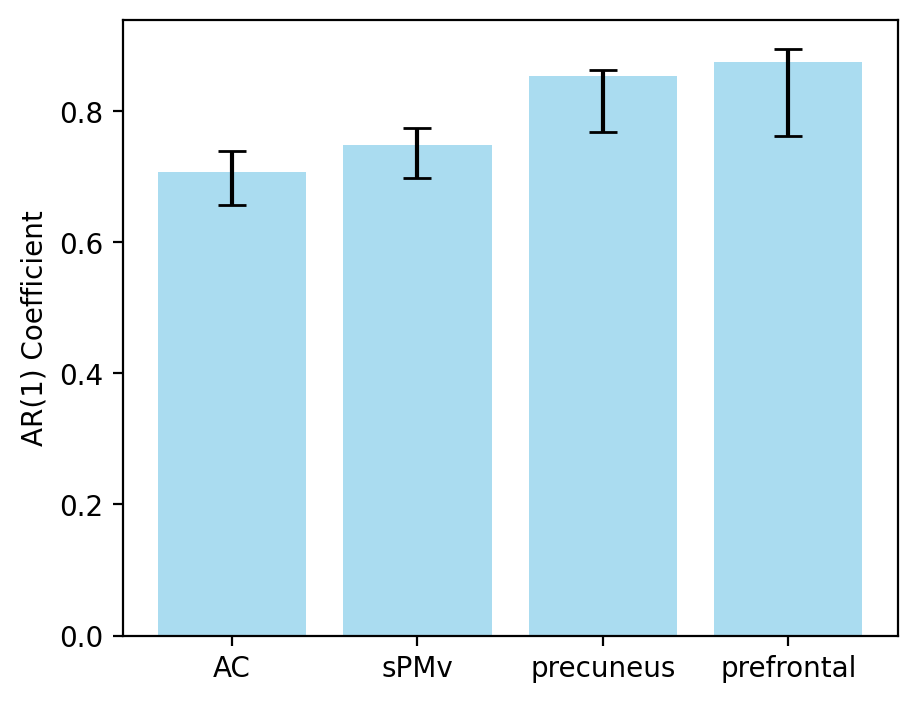

In [ ]:
if 0:    
    nruns = 10
    nboots = 100
    keys = roi_voxs.keys()
    null_dist = {key: np.zeros(nboots) for key in keys}

    for roi in roi_voxs:
        for i in range(nboots):
            sample_runs = np.random.choice(response_trials.shape[0], size = nruns, replace=True)
            sample_runs_resp = response_trials[sample_runs,:,:]
            roi_run_mean = np.mean(sample_runs_resp, axis=0)
            roi_vox_mean = zs(np.mean(roi_run_mean[:,roi_voxs[roi]], axis=1)) 
            ar1_model = sm.tsa.AutoReg(roi_vox_mean, lags = 1).fit()
            null_dist[roi][i] = ar1_model.params[1]

    # Compute 95% CI 
    ci = []
    for roi, dist in null_dist.items():
        lb = np.percentile(dist, 2.5)
        ub = np.percentile(dist, 97.5)
        ci.append((lb, ub))
    print("95% CI:", ci)

    ar1_coeff_est = []
    for roi in roi_ar1_coeff:
        ar1_coeff_est.append(roi_ar1_coeff[roi])
    print("AR(1) Coefficient Estimates:", ar1_coeff_est)

    lower_err = [ar1_coeff_est - ci[0] for ar1_coeff_est, ci in zip(ar1_coeff_est, ci)]
    upper_err = [ci[1] - ar1_coeff_est for ar1_coeff_est, ci in zip(ar1_coeff_est, ci)]
    err_bar = [lower_err, upper_err]

    rois = roi_voxs.keys()
    x = np.arange(len(rois))
    plt.figure(figsize = (5,4))
    plt.errorbar(x, ar1_coeff_est, yerr=err_bar, fmt='o', capsize=5, color='skyblue', alpha=0.7)

    plt.xticks(x, rois)
    plt.ylabel('AR(1) Coefficient')
    os.chdir(path=fig_path)
    plt.savefig("s2_main_results_95ci.pdf", format='pdf', bbox_inches='tight')
    plt.show()

#### Bootstrap to get 95% CI for recovered curvatures

Sample 10 runs with replacement, find run average and fit to AR(1) model for each ROI. Repeat this process 100 times to get the null distribution of AR(1) coefficients. Then get error bars to see if differences between ROIs are significant. 

In [ ]:
# --- bootstrap settings ---
nboots = 100
nruns  = response_trials.shape[0]   
nT     = response_trials.shape[1]

keys = roi_voxs.keys()

# store bootstrap recovered curvature
boot_rec_curv = {roi: np.zeros(nboots) for roi in keys}

for b in range(nboots):
    # sample runs with replacement
    sample_runs_idx  = np.random.choice(response_trials.shape[0],
                                        size=nruns,
                                        replace=True)
    sample_trials    = response_trials[sample_runs_idx, :, :]   # (nruns, nT, nVox)
    avg_reps_boot    = sample_trials.mean(axis=0)               # (nT, nVox) - run average

    for roi, vox_idx in roi_voxs.items():
        # 1) voxel-averaged, run-averaged time series for this ROI
        roi_ts_boot   = avg_reps_boot[:, vox_idx].mean(axis=1)  # (nT,)
        roi_ts_boot_z = zs(roi_ts_boot)

        # 2) fit AR(1) to that series
        ar1_model_boot = sm.tsa.AutoReg(roi_ts_boot_z, lags=1).fit()
        alpha_boot     = ar1_model_boot.params[1]

        # 3) simulate noiseless AR population for this ROI using alpha_boot
        n_voxs_roi = len(vox_idx)
        private_signal_innov_boot = np.random.randn(n_voxs_roi, nT) * private_signal_std
        roi_rec_noiseless_ts_boot = make_noiseless_arp(alpha_boot, nT,
                                                       n_voxs_roi,
                                                       private_signal_innov_boot)

        # 4) compute recovered curvature
        boot_rec_curv[roi][b] = avg_pop_curvature(roi_rec_noiseless_ts_boot)



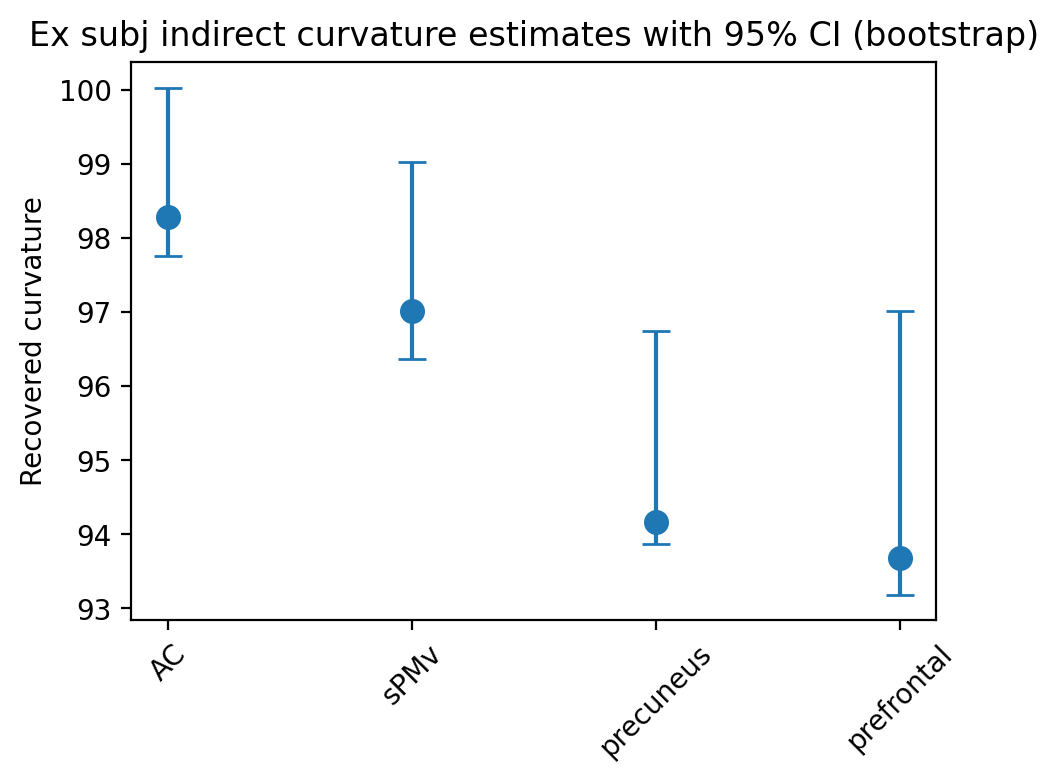

In [ ]:
# Plotting 
roi_names = list(roi_voxs.keys())

# point estimates: recovered curvature from full data
point_est = np.array([rec_noiseless_est_curv[roi] for roi in roi_names])

# bootstrap-based CIs
lower_err = []
upper_err = []

for roi, est in zip(roi_names, point_est):
    dist = boot_rec_curv[roi]
    lb   = np.percentile(dist, 2.5)
    ub   = np.percentile(dist, 97.5)
    lower_err.append(est - lb)
    upper_err.append(ub - est)

err_bar = [lower_err, upper_err]

x = np.arange(len(roi_names))
plt.figure(figsize=(5,4))
plt.errorbar(x, point_est, yerr=err_bar, fmt='o', capsize=5, markersize=8)
plt.xticks(x, roi_names, rotation=45)
# plt.ylim([90,120])
plt.ylabel("Recovered curvature")
plt.title("Ex subj indirect curvature estimates with 95% CI (bootstrap)")
plt.suptitle(f"{subject}, {story}, {response_trials.shape[0]} reps", fontsize=10, y=0.98)
plt.tight_layout()
plt.savefig("ex_subj_indirect_curv.pdf", format='pdf')
plt.show()

Get p-value: How extreme is ROI1's observed coefficient relative to the null distribution for ROI1?

In [ ]:
from scipy.stats import percentileofscore

roi_names = list(roi_voxs.keys())

p_values = []
for i, roi1 in enumerate(roi_names):
    for j, roi2 in enumerate(roi_names):
        if i != j:
            # ROI1's null distribution (bootstrapped recovered curvature)
            dist = boot_rec_curv[roi1]                   # array of shape (nboots,)

            # ROI2's observed recovered curvature
            obs = rec_noiseless_est_curv[roi2]          # scalar

            # Percentile of roi2's value in roi1's null
            percentile = percentileofscore(dist, obs, kind='rank')

            # Two-sided p-value
            p_value = 2 * min(percentile / 100.0, 1 - percentile / 100.0)
            p_values.append((roi1, roi2, p_value))

            print(f"p-value for {roi2} vs {roi1}'s null (curvature): {p_value:.4f}")


p-value for sPMv vs AC's null (curvature): 0.0000
p-value for precuneus vs AC's null (curvature): 0.0000
p-value for prefrontal vs AC's null (curvature): 0.0000
p-value for AC vs sPMv's null (curvature): 0.2600
p-value for precuneus vs sPMv's null (curvature): 0.0000
p-value for prefrontal vs sPMv's null (curvature): 0.0000
p-value for AC vs precuneus's null (curvature): 0.0000
p-value for sPMv vs precuneus's null (curvature): 0.0000
p-value for prefrontal vs precuneus's null (curvature): 0.0000
p-value for AC vs prefrontal's null (curvature): 0.0000
p-value for sPMv vs prefrontal's null (curvature): 0.0400
p-value for precuneus vs prefrontal's null (curvature): 0.4800


#### Control analysis

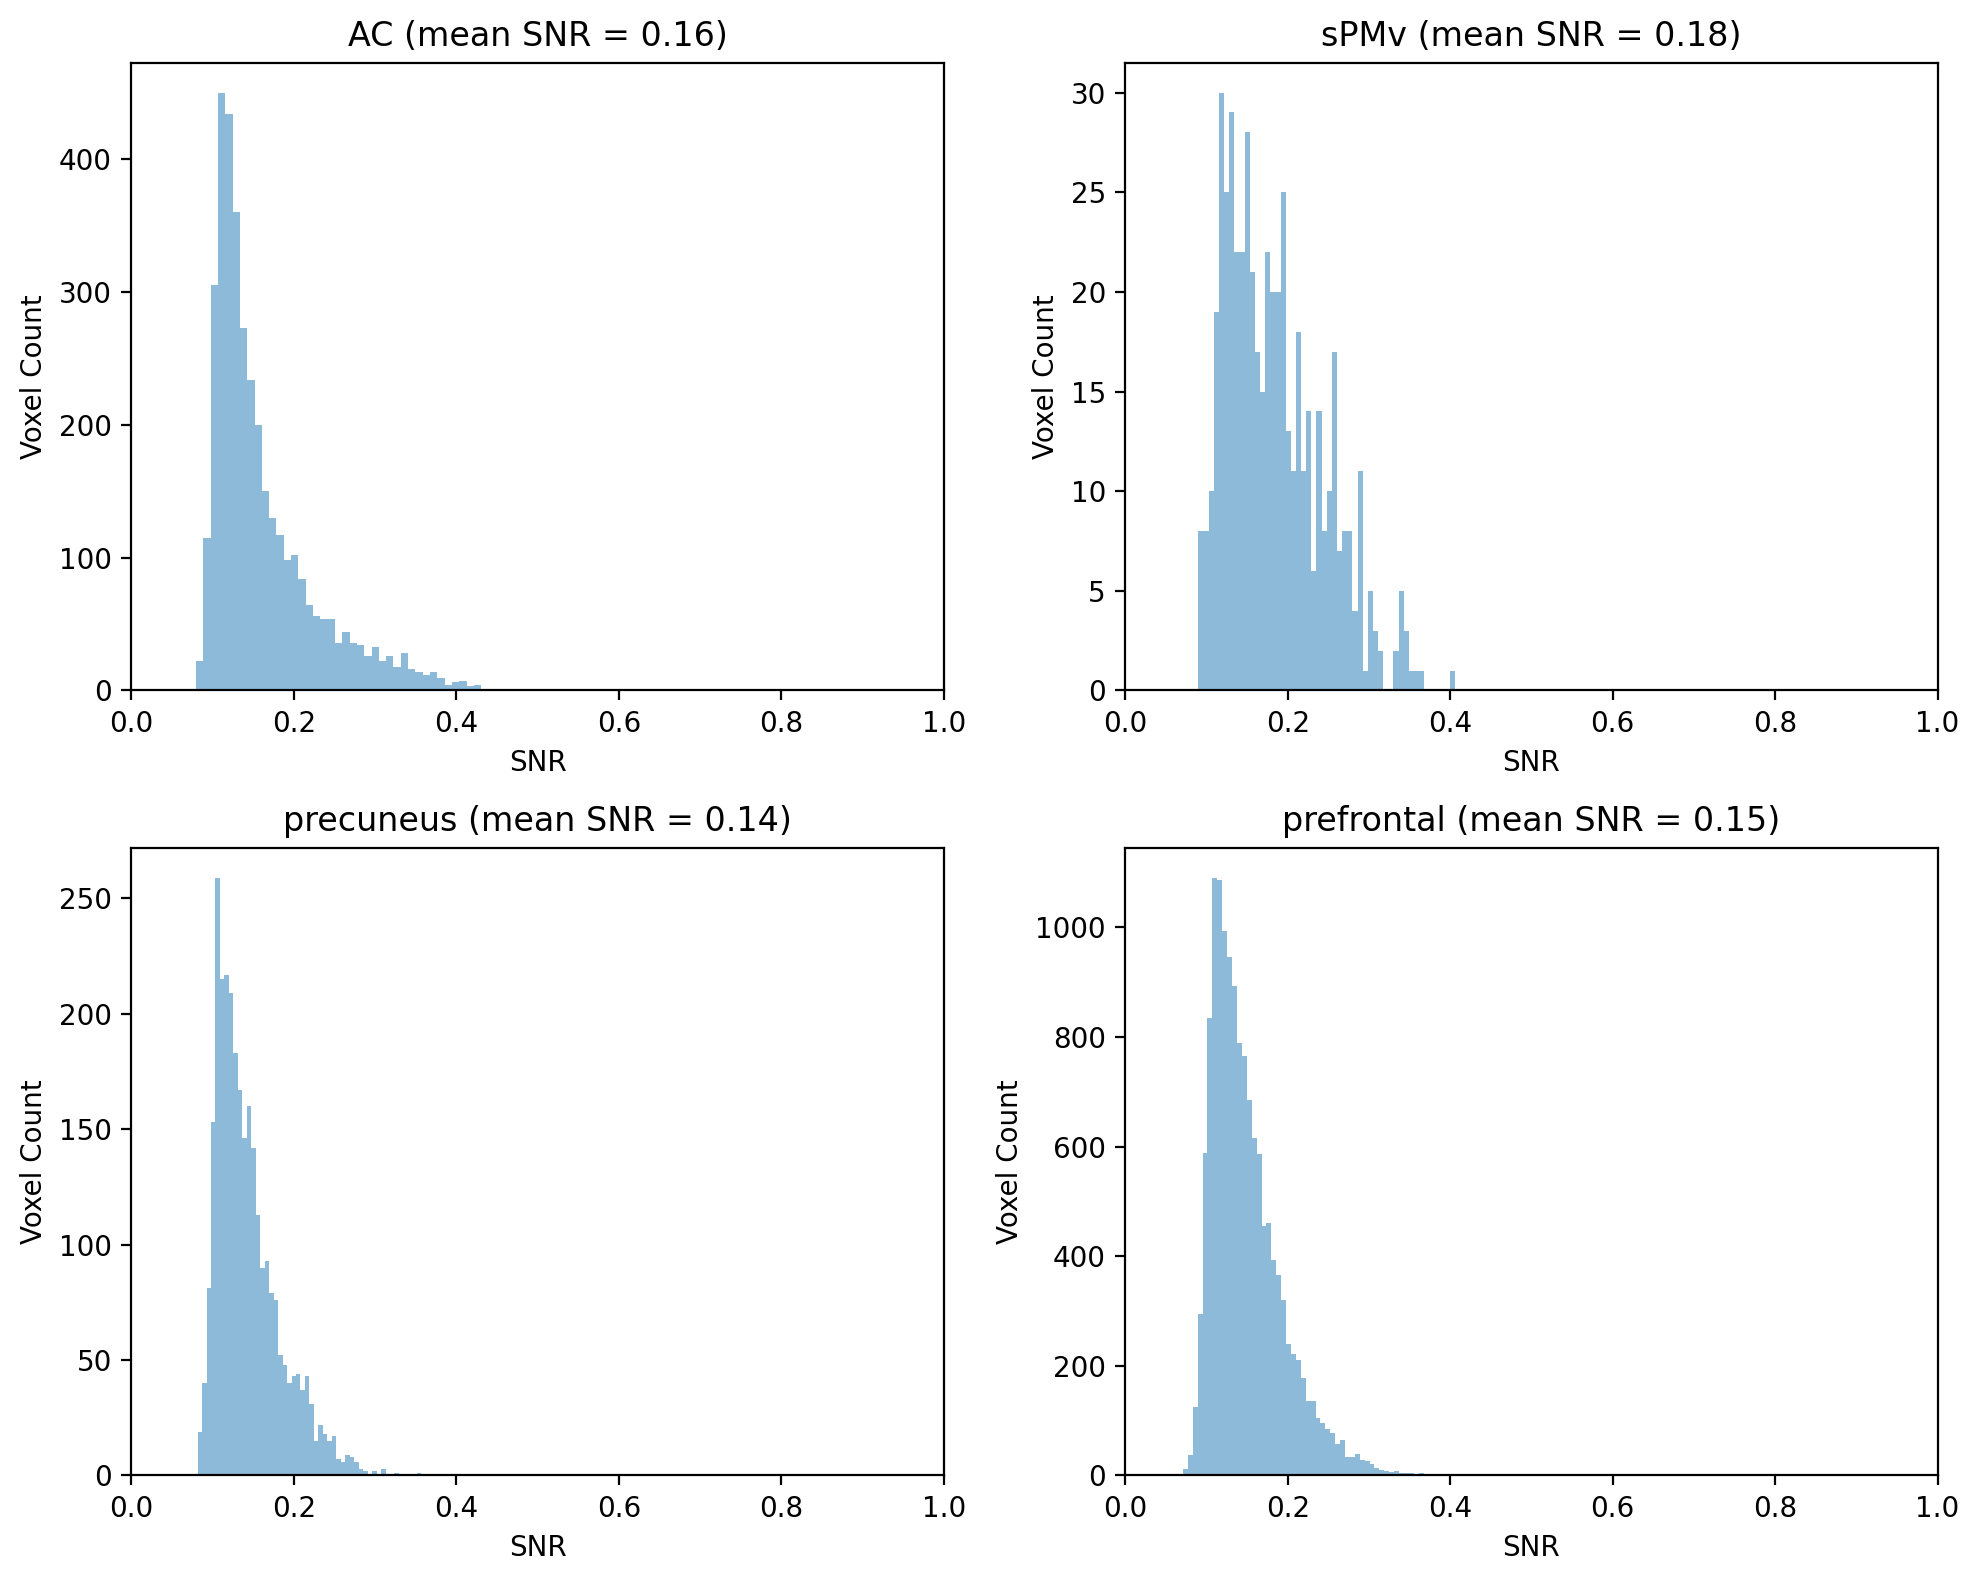

In [ ]:
def estimate_snr(response_trials):
    # response_trials should be ROI averaged data, with the shape (nRuns x nTimepoints)
    signal = np.mean(response_trials, axis=0)
    signal_var = np.var(signal, ddof=1)
    noise = response_trials - signal
    noise_var = np.var(noise, ddof=1) 
    snr = signal_var/(signal_var + noise_var) 
    return snr

roi_snrs = {}
for roi in roi_voxs:
    roi_snrs[roi] = []
    for roi_idx in roi_voxs[roi]:
        snr = estimate_snr(response_trials[:,:,roi_idx])
        roi_snrs[roi].append(snr)


rois = list(roi_snrs.keys())
n_rois = len(rois)
nrows, ncols = 2, 2

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 8))
axs = axs.flatten()  # make it easier to iterate over

for i, roi in enumerate(rois):
    snrs = roi_snrs[roi]
    mean = np.mean(snrs)

    ax = axs[i]
    ax.hist(snrs, bins=50, edgecolor='none', alpha=0.5)
    ax.set_title(f"{roi} (mean SNR = {mean:.2f})")
    ax.set_xlim([0, 1])
    ax.set_xlabel("SNR")
    ax.set_ylabel("Voxel Count")

# If you have fewer than 4 ROIs, hide unused axes
for j in range(len(rois), len(axs)):
    axs[j].axis("off")

plt.tight_layout()
os.chdir(path=fig_path)
# plt.savefig("roi_snr_dists.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# bin voxels based on SNRs
zs = lambda v: (v-v.mean(0))/v.std(0)
snr_bin_edges = np.arange(0.1,0.4,0.1)
bin_ids = {}
roi_bins = {}
for roi, snrs in roi_snrs.items():
    bin_ids[roi] = np.digitize(snrs, snr_bin_edges)
    roi_bins[roi] = {}
    for bin_id in np.unique(bin_ids[roi]):
        bin_voxels = [idx for idx, b in zip(roi_voxs[roi], bin_ids[roi]) if b == bin_id]
        roi_bins[roi][bin_id] = bin_voxels

est_alpha_snr = {}
for roi, bins in roi_bins.items():
    est_alpha_snr[roi] = {}
    for bin_id in bins:
        vox_idx_list = bins[bin_id]
        if len(vox_idx_list) == 0:
            continue
        binned_response = response_trials[:,:,vox_idx_list]
        zs_avg_resp = zs(np.mean(binned_response,axis=(0,2)))
        ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags = 1).fit()
        est_alpha_snr[roi][bin_id] = ar1_model.params[1]

In [ ]:
# Define bin edges again to map bin IDs to readable ranges
snr_bin_edges = np.arange(0.1, 0.4, 0.1)

# Print in desired format: ROI: snr bin (edge range): alpha
for roi, bins in est_alpha_snr.items():
    for bin_id, alpha in sorted(bins.items()):
        if bin_id ==0 or bin_id >= 4:
            continue
        if bin_id <= len(snr_bin_edges) - 1:
            bin_start = snr_bin_edges[bin_id - 1]
            bin_end = snr_bin_edges[bin_id]
            print(f"{roi}: SNR Bin {bin_id} ({bin_start:.1f}–{bin_end:.1f}): alpha = {alpha:.4f}")
        else:
            print(f"{roi}: SNR Bin {bin_id} (> {snr_bin_edges[-1]:.1f}): alpha = {alpha:.4f}")

AC: SNR Bin 1 (0.1–0.2): alpha = 0.8122
AC: SNR Bin 2 (0.2–0.3): alpha = 0.7530
AC: SNR Bin 3 (0.3–0.4): alpha = 0.7357
sPMv: SNR Bin 1 (0.1–0.2): alpha = 0.7870
sPMv: SNR Bin 2 (0.2–0.3): alpha = 0.7294
sPMv: SNR Bin 3 (0.3–0.4): alpha = 0.6994
precuneus: SNR Bin 1 (0.1–0.2): alpha = 0.8357
precuneus: SNR Bin 2 (0.2–0.3): alpha = 0.8527
precuneus: SNR Bin 3 (0.3–0.4): alpha = 0.8650
prefrontal: SNR Bin 1 (0.1–0.2): alpha = 0.9076
prefrontal: SNR Bin 2 (0.2–0.3): alpha = 0.8910
prefrontal: SNR Bin 3 (0.3–0.4): alpha = 0.8924


##### Bootstrap to get error bars for all SNR bins
Sample 10 runs with replacement, find run average and fit to AR(1) model for each ROI. Repeat this process 100 times to get the null distribution of AR(1) coefficients. Then get error bars to see if differences between ROIs are significant. 

In [ ]:
%time
nruns = 10
nboots = 1000
snr_bin_edges = np.arange(0.1,0.4,0.1)
null_dist_alpha_snr = {roi: {bin_id: [] for bin_id in range(1, len(snr_bin_edges)+1)} for roi in roi_voxs}

for i in range(nboots):
    sample_runs = np.random.choice(response_trials.shape[0], size=nruns, replace=True)
    sample_runs_resp = response_trials[sample_runs, :, :]  # shape: (nruns, time, voxels)
    roi_run_mean = np.mean(sample_runs_resp, axis=0)

    for roi in roi_voxs:
        # --- SNR estimation and binning ---
        voxel_snrs = [estimate_snr(sample_runs_resp[:, :, idx]) for idx in roi_voxs[roi]]
        bin_ids = np.digitize(voxel_snrs, snr_bin_edges)

        for bin_id in np.unique(bin_ids):
            if bin_id == 0:
                continue 
            vox_idx_list = [idx for idx, b in zip(roi_voxs[roi], bin_ids) if b == bin_id]
            if len(vox_idx_list) == 0:
                continue

            binned_response = sample_runs_resp[:, :, vox_idx_list]  # shape: (runs, time, voxels)
            avg_response = np.mean(binned_response, axis=(0, 2))    # shape: (time,)
            zs_avg_resp = zs(avg_response)

            ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags=1).fit()
            alpha_est = ar1_model.params[1]
            null_dist_alpha_snr[roi][bin_id].append(alpha_est)
        

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 μs


KeyboardInterrupt: 

In [ ]:
# percentile binning 
# Parameters
nruns = 10
nboots = 100
n_bins = 3  # number of percentile bins

# Initialize
null_dist_alpha_snr = {roi: {bin_id: [] for bin_id in range(1, n_bins + 1)} for roi in roi_voxs}

# Bootstrap loop
for i in range(nboots):
    sample_runs = np.random.choice(response_trials.shape[0], size=nruns, replace=True)
    sample_runs_resp = response_trials[sample_runs, :, :]  # shape: (nruns, time, voxels)

    for roi in roi_voxs:
        # --- Estimate SNRs for voxels in this ROI ---
        voxel_snrs = [estimate_snr(sample_runs_resp[:, :, idx]) for idx in roi_voxs[roi]]
        voxel_indices = roi_voxs[roi]

        # --- Percentile-based binning ---
        snr_percentiles = np.percentile(voxel_snrs, np.linspace(0, 100, n_bins + 1))
        bin_ids = np.digitize(voxel_snrs, snr_percentiles[1:-1], right=True) + 1  # bins = 1 to n_bins

        for bin_id in range(1, n_bins + 1):
            # Get voxel indices that fall into this bin
            vox_idx_list = [idx for idx, b in zip(voxel_indices, bin_ids) if b == bin_id]
            if len(vox_idx_list) == 0:
                continue

            # Average across selected voxels and runs
            binned_response = sample_runs_resp[:, :, vox_idx_list]  # shape: (runs, time, voxels)
            avg_response = np.mean(binned_response, axis=(0, 2))    # shape: (time,)
            zs_avg_resp = zs(avg_response)

            # Fit AR(1) model and store alpha estimate
            ar1_model = sm.tsa.AutoReg(zs_avg_resp, lags=1).fit()
            alpha_est = ar1_model.params[1]
            null_dist_alpha_snr[roi][bin_id].append(alpha_est)


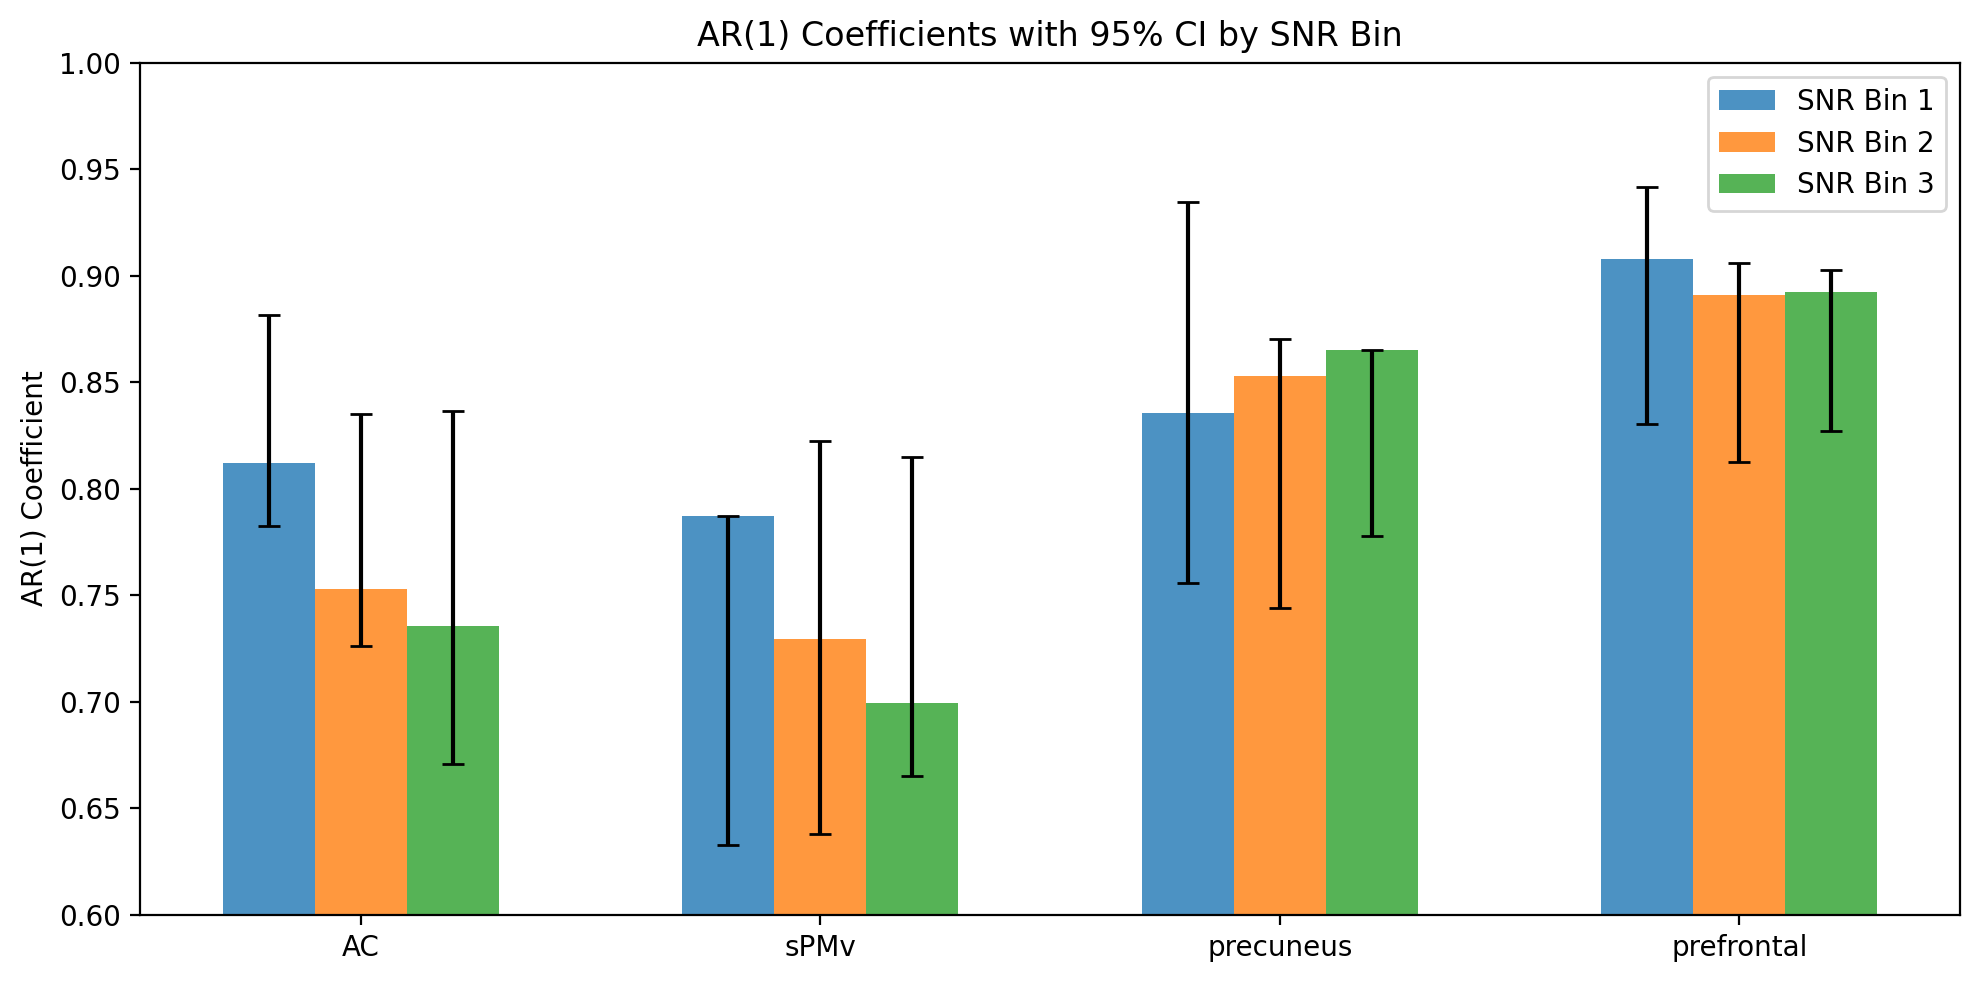

In [ ]:
# this plot is clipped to show only non-negative values
snr_bins = [1, 2, 3]
rois = list(null_dist_alpha_snr.keys())

# Prepare data
bar_width = 0.2
x = np.arange(len(rois))

fig, ax = plt.subplots(figsize=(10, 5))

for i, bin_id in enumerate(snr_bins):
    ar1_coeff_est = []
    lower_err = []
    upper_err = []

    for roi in rois:
        # Get observed alpha for this ROI and bin
        if roi in est_alpha_snr and bin_id in est_alpha_snr[roi]:
            obs_alpha = est_alpha_snr.get(roi, {}).get(bin_id, np.nan)
        else:
            obs_alpha = np.nan  # fallback if missing
        ar1_coeff_est.append(obs_alpha)

        # Get 95% CI from bootstrapped distribution
        boot_dist = null_dist_alpha_snr.get(roi, {}).get(bin_id, [])
        if len(boot_dist) > 0:
            lb = np.percentile(boot_dist, 2.5)
            ub = np.percentile(boot_dist, 97.5)
            # Clip error bars to ensure non-negative values
            lower = max(0, obs_alpha - lb)
            upper = max(0, ub - obs_alpha)
        else:
            lower, upper = np.nan, np.nan

        lower_err.append(lower)
        upper_err.append(upper)

    # Plot bars with offset for each bin
    bar_positions = x + (i - 1) * bar_width
    ax.bar(bar_positions, ar1_coeff_est, yerr=[lower_err, upper_err],
           width=bar_width, capsize=4, label=f'SNR Bin {bin_id}', alpha=0.8)

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(rois)
ax.set_ylim([0.6, 1])
ax.set_ylabel('AR(1) Coefficient')
ax.set_title('AR(1) Coefficients with 95% CI by SNR Bin')
ax.legend()
plt.tight_layout()
os.chdir(path=fig_path)
plt.savefig("snr_control_results_95ci.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
from itertools import combinations, permutations

pairwise_pvals = []

for bin_id in snr_bins:
    for roi_A, roi_B in permutations(rois, 2):  # all ordered pairs where A ≠ B
        if bin_id not in est_alpha_snr[roi_A] or bin_id not in null_dist_alpha_snr[roi_B]:
            continue

        obs = est_alpha_snr[roi_A][bin_id]
        null = null_dist_alpha_snr[roi_B][bin_id]

        # Two-tailed p-value: is A's value surprising under B's null?
        p_low = np.mean(null <= obs)
        p_high = np.mean(null >= obs)
        p_val = 2 * min(p_low, p_high)
        p_val = min(p_val, 1.0)

        pairwise_pvals.append((bin_id, roi_A, roi_B, p_val))

# Print it
print("\nPairwise p-values by SNR bin:")
for bin_id, roi_A, roi_B, p_val in pairwise_pvals:
    print(f"SNR Bin {bin_id}: {roi_A} vs {roi_B}'s null → p = {p_val:.4f}")




Pairwise p-values by SNR bin:
SNR Bin 1: AC vs sPMv's null → p = 0.0091
SNR Bin 1: AC vs precuneus's null → p = 0.8268
SNR Bin 1: AC vs prefrontal's null → p = 0.4016
SNR Bin 1: sPMv vs AC's null → p = 0.6255
SNR Bin 1: sPMv vs precuneus's null → p = 0.5781
SNR Bin 1: sPMv vs prefrontal's null → p = 0.3489
SNR Bin 1: precuneus vs AC's null → p = 0.6362
SNR Bin 1: precuneus vs sPMv's null → p = 0.0000
SNR Bin 1: precuneus vs prefrontal's null → p = 0.4422
SNR Bin 1: prefrontal vs AC's null → p = 0.0000
SNR Bin 1: prefrontal vs sPMv's null → p = 0.0000
SNR Bin 1: prefrontal vs precuneus's null → p = 0.0956
SNR Bin 2: AC vs sPMv's null → p = 0.8277
SNR Bin 2: AC vs precuneus's null → p = 0.0960
SNR Bin 2: AC vs prefrontal's null → p = 0.0200
SNR Bin 2: sPMv vs AC's null → p = 0.2140
SNR Bin 2: sPMv vs precuneus's null → p = 0.0360
SNR Bin 2: sPMv vs prefrontal's null → p = 0.0160
SNR Bin 2: precuneus vs AC's null → p = 0.0080
SNR Bin 2: precuneus vs sPMv's null → p = 0.0000
SNR Bin 2: pr